* 任务一：对获取到的数据集进行预处理并提取特征。
* 任务二：用LDA对数据集进行降维，并进行可视化分析。


## 1、获取鸢尾花数据集

In [1]:
import pandas as pd

feature_dict = {i: label for i, label in zip(range(4),
                                             ('sepal length in cm', 'sepal width in cm', 'petal length in cm',
                                              'petal width in cm'))}
df = pd.io.parsers.read_csv("./data/iris.data", header=None, sep=',')
df.columns = [l for i, l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True)
df.tail(5)


,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


## 2、将数据进行预处理，X表示特征，y表示标签

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df[['sepal length in cm', 'sepal width in cm',
        'petal length in cm', 'petal width in cm']].values
y = df['class label'].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3: 'Virginica'}

## 3、分别求三种鸢尾花数据在不同特征维度上的均值向量

In [3]:

import numpy as np

# 小数点后四位
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1, 4):
    mean_vectors.append(np.mean(X[y == cl], axis=0))
    print('Mean Vector class {}:{}'.format(cl, mean_vectors[cl - 1]))


Mean Vector class 1:[5.006 3.418 1.464 0.244]
Mean Vector class 2:[5.936 2.77  4.26  1.326]
Mean Vector class 3:[6.588 2.974 5.552 2.026]


## 4、分别计算类内散布矩阵和类间散布矩阵

In [4]:

# 类内散布矩阵：
S_W = np.zeros((4, 4))
for cl, mv in zip(range(1, 4), mean_vectors):
    class_sc_mat = np.zeros((4, 4))
    for row in X[y == cl]:
        row, mv = row.reshape(4, 1), mv.reshape(4, 1)
        class_sc_mat += (row - mv).dot((row - mv).T)
    S_W += class_sc_mat
print('within-class Scatter Matrix:\n', S_W)


within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [5]:
# 类间散布矩阵：
overall_mean = np.mean(X, axis=0)
S_B = np.zeros((4, 4))
for i, mv in enumerate(mean_vectors):
    n = X[y == i + 1, :].shape[0]
    mv = mv.reshape(4, 1)
    overall_mean = overall_mean.reshape(4, 1)
    S_B += n * (mv - overall_mean).dot((mv - overall_mean).T)
print('between-class Scatter Matrix:\n', S_B)


between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


## 5、求解矩阵的特征值

In [6]:
# linalg线性代数模块，eig求解特征值和特征向量，inv求解逆矩阵
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:, i].reshape(4, 1)
    print('\nEigenvector {}:\n{}'.format(i + 1, eigvec_sc.real))
    print('Eigenvalue {:}:{:.2e}'.format(i + 1, eig_vals[i].real))


Eigenvector 1:
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1:3.23e+01

Eigenvector 2:
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2:2.78e-01

Eigenvector 3:
[[-0.2122]
 [-0.2111]
 [-0.2751]
 [ 0.767 ]]
Eigenvalue 3:3.31e-15

Eigenvector 4:
[[-0.2122]
 [-0.2111]
 [-0.2751]
 [ 0.767 ]]
Eigenvalue 4:3.31e-15


## 6、按特征值大小进行排序

In [7]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i])
             for i in range(len(eig_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:')
for i in eig_pairs:
    print(i[0])


Eigenvalues in decreasing order:
32.2719577997298
0.27756686384004753
6.935906860079299e-15
6.935906860079299e-15


## 7、衡量特征值的重要程度

In [8]:
print('Variance explained:')
eigv_sum = sum(eig_vals)
for i, j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i + 1, (j[0] / eigv_sum).real))


Variance explained:
eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


## 8、根据重要程度，选择前两维特征

In [9]:
W = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


## 9、降维

In [10]:
X_lda = X.dot(W)
assert X_lda.shape == (150, 2), "The matrix is not 150x2 dimensional."

## 10、画图函数

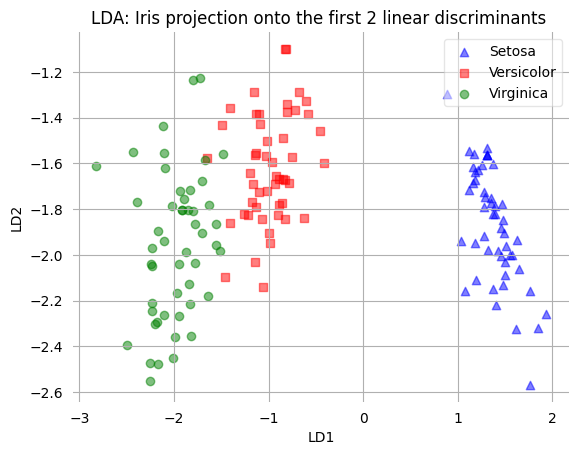

In [11]:
import matplotlib.pyplot as plt

def plot_step_lda():
    ax = plt.subplot(111)
    for label, marker, color in zip(range(1, 4), ('^', 's', 'o'), ('blue', 'red', 'green')):
        plt.scatter(x=X_lda[:, 0].real[y == label], y=X_lda[:, 1].real[y == label],
                    marker=marker, color=color, alpha=0.5, label=label_dict[label])
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants ')
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True)
    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.grid()
    plt.tight_layout
    plt.show()


plot_step_lda()


##  11、sklearn中的LDA降维

In [12]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

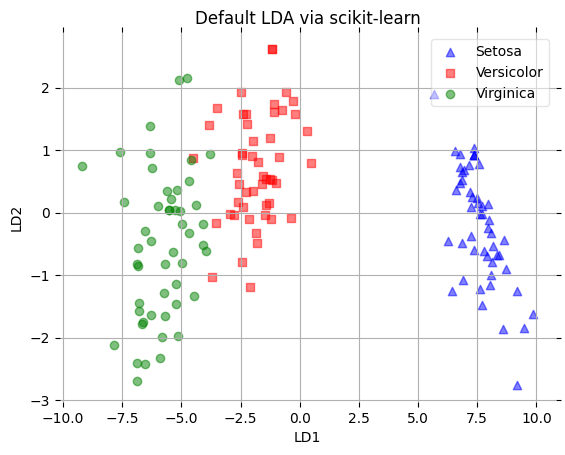

In [13]:
def plot_scikit_lda(X, title):
    ax = plt.subplot(111)
    for label, marker, color in zip(
            range(1, 4), ('^', 's', 'o'), ('blue', 'red', 'green')):
        plt.scatter(x=X[:, 0][y == label],
                    y=X[:, 1][y == label] * -1,  # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()


plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')